In [6]:
import pandas as pd
import numpy as np
import spacy
import nltk
import string
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch

## Loading data

In [7]:
df = pd.read_csv('england_recent.csv')

In [8]:
df.head()

,firm,date_review,job_title,current,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,outlook,headline,pros,cons,year
0,AFH-Wealth-Management,2015-12-11,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",2,3.0,1.0,NaN,2.0,1.0,4.0,x,o,r,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...,2015
1,AFH-Wealth-Management,2016-01-28,Office Administrator,"Current Employee, less than 1 year","Bromsgrove, England, England",1,1.0,1.0,NaN,1.0,1.0,1.0,x,o,x,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very...",2016
2,AFH-Wealth-Management,2016-04-23,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",1,2.0,1.0,NaN,2.0,1.0,1.0,x,o,x,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr...",2016
3,AFH-Wealth-Management,2016-09-23,IFA,Former Employee,"Bromsgrove, England, England",1,1.0,1.0,NaN,1.0,1.0,1.0,x,o,r,It horrible management,Good investment management strategy. Overall t...,The management and seniors are ruthless. No tr...,2016
4,AFH-Wealth-Management,2017-05-21,Administrative Support,"Former Employee, more than 5 years","Birmingham, England, England",1,4.0,1.0,NaN,2.0,4.0,1.0,o,v,v,Administration team,Free parking . Meet some nice people in the te...,Not treated at all well after 6 yrs of being a...,2017


In [9]:
df['firm'] = df['firm'].str.replace('-', ' ')
# Load the suggestion list
suggestion_df = pd.read_csv("Refined_Industry_and_Suggestion_List.csv")

# Filter for rows where suggestion is "remove"
firms_to_remove = suggestion_df[suggestion_df["suggestion"] == "remove"]["firm"].dropna().unique()

# Filter the main DataFrame
df = df[~df["firm"].isin(firms_to_remove)]

dffirms = df.groupby('firm').size().reset_index(name='Count')

df.to_csv('filtered_england_recent.csv')

## sample 10% of data, preprocess (lematization, no stopwords removal!)

In [3]:
from tqdm.notebook import tqdm
tqdm.pandas()

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

# Sample 10% of the data 
df_sample = df.sample(frac=0.1, random_state=21).copy()
#df_sample = df.copy()

#only lematizing, want to keep as many words as possible. 
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    doc = nlp(text.lower())
    return " ".join(token.lemma_ for token in doc if not token.is_punct and not token.is_space)


# Apply preprocessing with progress bar
for col in ['pros', 'cons']:
    print(f"Processing column: {col}")
    df_sample[f'{col}_clean'] = df_sample[col].progress_apply(preprocess_text)

# Preview result
df_sample[['pros_clean', 'cons_clean']].head()

Processing column: pros


  0%|          | 0/12762 [00:00<?, ?it/s]

Processing column: cons


  0%|          | 0/12762 [00:00<?, ?it/s]

,pros_clean,cons_clean
73417,good environment free food flexible hour,night shift compulsory low pay
59426,invest heavily in you to get you promote,abandon you when contract be lose
10562,good company to work for,no downside to work here
50951,excellent salary colleague can be quite friend...,almost sexist mindset difficult to learn train...
88667,alright for a first job some supervisor be ver...,very low pay force to stand in one place for 8...


In [4]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

## Getting rid of the ultra long reviews as they are hard to tokenize

In [5]:
def is_too_long(text, max_tokens=300):
    try:
        prompt = f"Sentiment toward 'placeholder': {text.strip()}"
        tokens = tokenizer(prompt, return_tensors="pt", truncation=False)
        return tokens["input_ids"].shape[1] > max_tokens
    except:
        return True  # Skip anything that breaks

df_sample['too_long_pro'] = df_sample['pros'].apply(lambda x: is_too_long(x, max_tokens=300))
df_sample['too_long_con'] = df_sample['cons'].apply(lambda x: is_too_long(x, max_tokens=300))

# Filter them out
df_sample = df_sample[~(df_sample['too_long_pro'] | df_sample['too_long_con'])]


Token indices sequence length is longer than the specified maximum sequence length for this model (579 > 512). Running this sequence through the model will result in indexing errors


## Moving to ASBA analysis

In [6]:
def get_aspect_sentiment(text, aspect, tone):
    if pd.isnull(text):
        return None

    # Compose prompt-like input for aspect analysis
    if tone == 'pos':
        combined = f"The following is a positive experience about {aspect}: {text}"
    else:
        combined = f"The following is a negative experience about {aspect}: {text}"

    inputs = tokenizer(combined, return_tensors="pt", truncation=True, max_length=512)

    with torch.no_grad():
        logits = model(**inputs).logits
    scores = softmax(logits.numpy()[0])

    # This model returns scores for: [1 star, 2 stars, 3 stars, 4 stars, 5 stars]
    star_labels = [1, 2, 3, 4, 5]
    result = dict(zip(star_labels, scores))
    result["label"] = star_labels[scores.argmax()]
    return result


In [7]:
df_sample = df_sample[
    (df_sample['pros_clean'].str.strip() != '') & (df_sample['cons_clean'].str.strip() != '')
]
print("Empty pros_clean:", (df_sample['pros_clean'].str.strip() == '').sum())
print("Empty cons_clean:", (df_sample['cons_clean'].str.strip() == '').sum())


Empty pros_clean: 0
Empty cons_clean: 0


In [8]:
from collections import Counter
failed_sentiment = Counter()

def analyze_all_aspect_groups(text, aspect_groups, tone):
    results = {}
    for aspect, keywords in aspect_groups.items():
        if any(kw in text.lower() for kw in keywords):
            sent = get_aspect_sentiment(text, aspect, tone)
            if sent:
                results[aspect] = sent
            else:
                failed_sentiment[aspect] += 1  # Track failures
    return results


## Adding marie's dynamic aspect detection

In [9]:
from pyabsa import ATEPCCheckpointManager

# Load ABSA model
aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(
    checkpoint='english',
    auto_device=True
)

# Clean for ABSA
def clean_min(text):
    if not isinstance(text, str):
        return ""
    return text.replace('\n', ' ').replace('\r', '').encode("ascii", errors="ignore").decode().strip()

df_sample['min_prep_pros'] = df_sample['pros'].apply(clean_min)
df_sample['min_prep_cons'] = df_sample['cons'].apply(clean_min)

# Sample for ABSA (adjust size as needed)
texts_pros = df_sample['min_prep_pros'].dropna().sample(frac=0.2, random_state=42).tolist()
texts_cons = df_sample['min_prep_cons'].dropna().sample(frac=0.2, random_state=42).tolist()

# Extract aspects from pros and cons
absa_results_pros = aspect_extractor.extract_aspect(inference_source=texts_pros, print_result=False)
absa_results_cons = aspect_extractor.extract_aspect(inference_source=texts_cons, print_result=False)

# Collect discovered aspects
from collections import Counter

aspect_counter = Counter()
for result in absa_results_pros + absa_results_cons:
    for asp in result.get("aspect", []):
        aspect_counter[asp.lower()] += 1

# Show top discovered aspects
top_aspects = [asp for asp, count in aspect_counter.items() if count >= 3]
print(f"Top discovered aspects: {top_aspects}")


No CUDA GPU found in your device


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/bin/sh: nvidia-smi: command not found
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(tru

[2025-04-20 11:09:29] (2.4.1.post1) PyABSA(2.4.1.post1): If your code crashes on Colab, please use the GPU runtime. Then run "pip install pyabsa[dev] -U" and restart the kernel.
Or if it does not work, you can use v1.x versions, e.g., pip install pyabsa<2.0 -U




Try to downgrade transformers<=4.29.0.






huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/opt/anaconda3/lib/python3.12/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


[2025-04-20 11:09:39] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2025-04-20 11:09:39] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2025-04-20 11:09:39] (2.4.1.post1) Downloading checkpoint:english 
[2025-04-20 11:09:39] (2.4.1.post1) Notice: The pretrained model are used for testing, it is recommended to train the model on your own custom datasets
[2025-04-20 11:09:39] (2.4.1.post1) Checkpoint already downloaded, skip
[2025-04-20 11:09:40] (2.4.1.post1) Load aspect extractor from checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43
[2025-04-20 11:09:40] (2.4.1.post1) config: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.config
[2025-04-20 11:09:40] (2.4.1.post1) state_dict: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apc

<frozen importlib._bootstrap>:488: DeprecationWarning: Type google.protobuf.pyext._message.ScalarMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.
<frozen importlib._bootstrap>:488: DeprecationWarning: Type google.protobuf.pyext._message.MessageMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.
/opt/anaconda3/lib/python3.12/site-packages/google/protobuf/internal/well_known_types.py:91: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  _EPOCH_DATETIME_NAIVE = datetime.datetime.utcfromtimestamp(0)
/opt/anaconda3/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are 

[2025-04-20 11:38:25] (2.4.1.post1) The results of aspect term extraction have been saved in /Users/javirubio/Bocconi/02-SEM/Natural Language Processing/Final project/glassdoor_reviews/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json


classifying aspect sentiments: 100%|██████████| 80/80 [13:19<00:00,  9.99s/it]


[2025-04-20 12:04:32] (2.4.1.post1) The results of aspect term extraction have been saved in /Users/javirubio/Bocconi/02-SEM/Natural Language Processing/Final project/glassdoor_reviews/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
Top discovered aspects: ['staff', 'training', 'benefits', 'pension', 'people', 'discount', 'atmosphere', 'employees', 'content', 'collaboration', 'manager', 'environment', 'food', 'management', 'pay', 'perks', 'team', 'colleagues', 'customers', 'university', 'community', 'skills', 'brand', 'ceo', 'culture', 'employee benefits', 'locations', 'facilities', 'courses', 'values', 'money', 'teams', 'resources', 'learn', 'hours', 'canteen', 'overtime', 'learning', 'place', 'holidays', 'meals', 'everyone', 'recruitment', 'office', 'promotions', 'conditions', 'paid', 'commute', 'bonus', 'systems', 'technology', 'reward', 'salary', 'benefit', 'holiday', 'opportunities', 'flexible', 'flexibility', 'meal', 'managers', 'job', 'commission', 

In [10]:
top_aspects

['staff',
 'training',
 'benefits',
 'pension',
 'people',
 'discount',
 'atmosphere',
 'employees',
 'content',
 'collaboration',
 'manager',
 'environment',
 'food',
 'management',
 'pay',
 'perks',
 'team',
 'colleagues',
 'customers',
 'university',
 'community',
 'skills',
 'brand',
 'ceo',
 'culture',
 'employee benefits',
 'locations',
 'facilities',
 'courses',
 'values',
 'money',
 'teams',
 'resources',
 'learn',
 'hours',
 'canteen',
 'overtime',
 'learning',
 'place',
 'holidays',
 'meals',
 'everyone',
 'recruitment',
 'office',
 'promotions',
 'conditions',
 'paid',
 'commute',
 'bonus',
 'systems',
 'technology',
 'reward',
 'salary',
 'benefit',
 'holiday',
 'opportunities',
 'flexible',
 'flexibility',
 'meal',
 'managers',
 'job',
 'commission',
 'services',
 'work',
 'location',
 'pros',
 'diversity',
 'company',
 'gym',
 'clients',
 'health',
 'employee',
 'offices',
 'knowledge',
 'wages',
 'projects',
 'business',
 'leadership',
 'jobs',
 'rewards',
 'travel',
 'c

In [11]:
from collections import Counter

# Combine pros and cons into one string per row
combined_texts = (
    df_sample['min_prep_pros'].fillna('') + ' ' + df_sample['min_prep_cons'].fillna('')
).str.lower()

# Count how many unique reviews mention each aspect
aspect_review_counts = {asp: combined_texts.str.contains(rf'\b{asp.lower()}\b').sum() for asp in top_aspects}

# Display sorted
print("\n🧾 Number of Reviews Mentioning Each Auto-Detected Aspect (Unique Mentions Only):")
for asp, count in sorted(aspect_review_counts.items(), key=lambda x: -x[1]):
    print(f"{asp:<15}: {count}")



🧾 Number of Reviews Mentioning Each Auto-Detected Aspect (Unique Mentions Only):
work           : 5061
people         : 2834
management     : 2462
pay            : 2428
working        : 2243
hours          : 2128
staff          : 2103
it             : 2084
company        : 1943
team           : 1484
benefits       : 1398
opportunities  : 1364
job            : 1324
time           : 1309
environment    : 1291
training       : 1240
flexible       : 1210
culture        : 1048
salary         : 1001
managers       : 991
place          : 986
progression    : 983
career         : 981
balance        : 973
colleagues     : 925
life balance   : 876
support        : 769
discount       : 656
business       : 617
development    : 608
employees      : 602
experience     : 566
office         : 559
customers      : 555
opportunity    : 522
times          : 514
manager        : 509
day            : 472
cons           : 443
change         : 442
shifts         : 423
atmosphere     : 411
bonus          : 

## Here we should go to manually add things to the list

In [12]:
aspect_groups = {
    "pay": ["pay", "salary", "compensation", "wage", "income", "bonus"],
    "management": ["management", "managers", "leadership", "boss", "supervisor"],
    "work-life balance": ["work-life balance", "balance", "working hours", "hours", "flexibility", "overtime", "holiday"],
    "growth": ["growth", "grow", "career", "promotion", "advancement", "development", "opportunity", "progress"],
    "stress & pressure": ["stress", "pressure", "burnout", "demanding", "high pressure", "overload", "long hours", "stressful"],
    "culture": ["culture", "environment", "atmosphere", "company culture", "values"],
    "diversity & inclusion": ["diversity", "inclusion", "equality", "equity", "inclusive", "minority", "belonging"],
    "travel": ["travel", "commute", "commuting", "relocation", "mobility"],
    "benefits": ["benefits", "perks", "healthcare", "insurance", "pension", "rewards", "gym", "lunch", "dental"],
    "remote work": ["remote", "work from home", "wfh", "home office", "hybrid", "telework"],
    "flexibility": ["flexible", "flexibility", "adjustable schedule", "shift", "adaptable"],
    "people": ["people", "colleagues", "collegues", "coworker", "coworkers", "community", "teammates"],
    "training & onboarding": ["training", "onboarding", "orientation", "new hire", "introduction", "induction"],
    "job role clarity": ["role", "responsibility", "job description", "tasks", "duties", "expectation", "scope"],
    "tools & resources": ["tools", "resources", "equipment", "software", "support", "access", "tech stack", "technology"],
    "performance feedback": ["feedback", "review", "appraisal", "evaluation", "performance", "supervision", "goals"],
    "job security": ["job security", "layoff", "firing", "termination", "redundancy", "stable job"],
    "teamwork & collaboration": ["team", "teamwork", "collaboration", "supportive", "helpful", "team spirit", "group"]
}
def safe_analyze(text, aspect_groups, tone):
    try:
        return analyze_all_aspect_groups(text, aspect_groups, tone)
    except Exception as e:
        print(f"Failed on: {repr(text)}\nError: {e}")
        return {}

# Modified ABSA to use grouped aspect synonyms

df_sample['Clean_pro_aspect_sentiments'] = df_sample['pros_clean'].progress_apply(lambda x: analyze_all_aspect_groups(x, aspect_groups, tone='pos'))
df_sample['Clean_con_aspect_sentiments'] = df_sample['cons_clean'].progress_apply(lambda x: analyze_all_aspect_groups(x, aspect_groups, tone='neg'))

df_sample['pro_aspect_sentiments'] = df_sample['pros'].progress_apply(lambda x: analyze_all_aspect_groups(x, aspect_groups, tone='pos'))
df_sample['con_aspect_sentiments'] = df_sample['cons'].progress_apply(lambda x: analyze_all_aspect_groups(x, aspect_groups, tone='neg'))

  0%|          | 0/12636 [00:00<?, ?it/s]

  0%|          | 0/12636 [00:00<?, ?it/s]

  0%|          | 0/12636 [00:00<?, ?it/s]

  0%|          | 0/12636 [00:00<?, ?it/s]

Applying aspect group to uncleaned pros/cons worked better since it maintains more context

leaving both in df but should go with the non clean ones

In [13]:
# Full list of all aspect labels from your aspect_groups
all_aspects = list(aspect_groups.keys())
pro_counts= Counter()
con_counts = Counter()
pro_counts_clean = Counter()
con_counts_clean = Counter()

for row in df_sample['pro_aspect_sentiments'].dropna():
    pro_counts.update(row.keys())
for row in df_sample['con_aspect_sentiments'].dropna():
    con_counts.update(row.keys())

for row in df_sample['Clean_pro_aspect_sentiments'].dropna():
    pro_counts_clean.update(row.keys())
for row in df_sample['Clean_con_aspect_sentiments'].dropna():
    con_counts_clean.update(row.keys())


# Ensure all aspects appear, even if 0
pro_data = [(aspect, pro_counts.get(aspect, 0)) for aspect in all_aspects]
con_data = [(aspect, con_counts.get(aspect, 0)) for aspect in all_aspects]

# Sort by count
pro_data.sort(key=lambda x: x[1])
con_data.sort(key=lambda x: x[1])

# Ensure all aspects appear, even if 0
pro_data_clean = [(aspect, pro_counts_clean.get(aspect, 0)) for aspect in all_aspects]
con_data_clean = [(aspect, con_counts_clean.get(aspect, 0)) for aspect in all_aspects]

# Sort by count
pro_data_clean.sort(key=lambda x: x[1])
con_data_clean.sort(key=lambda x: x[1])

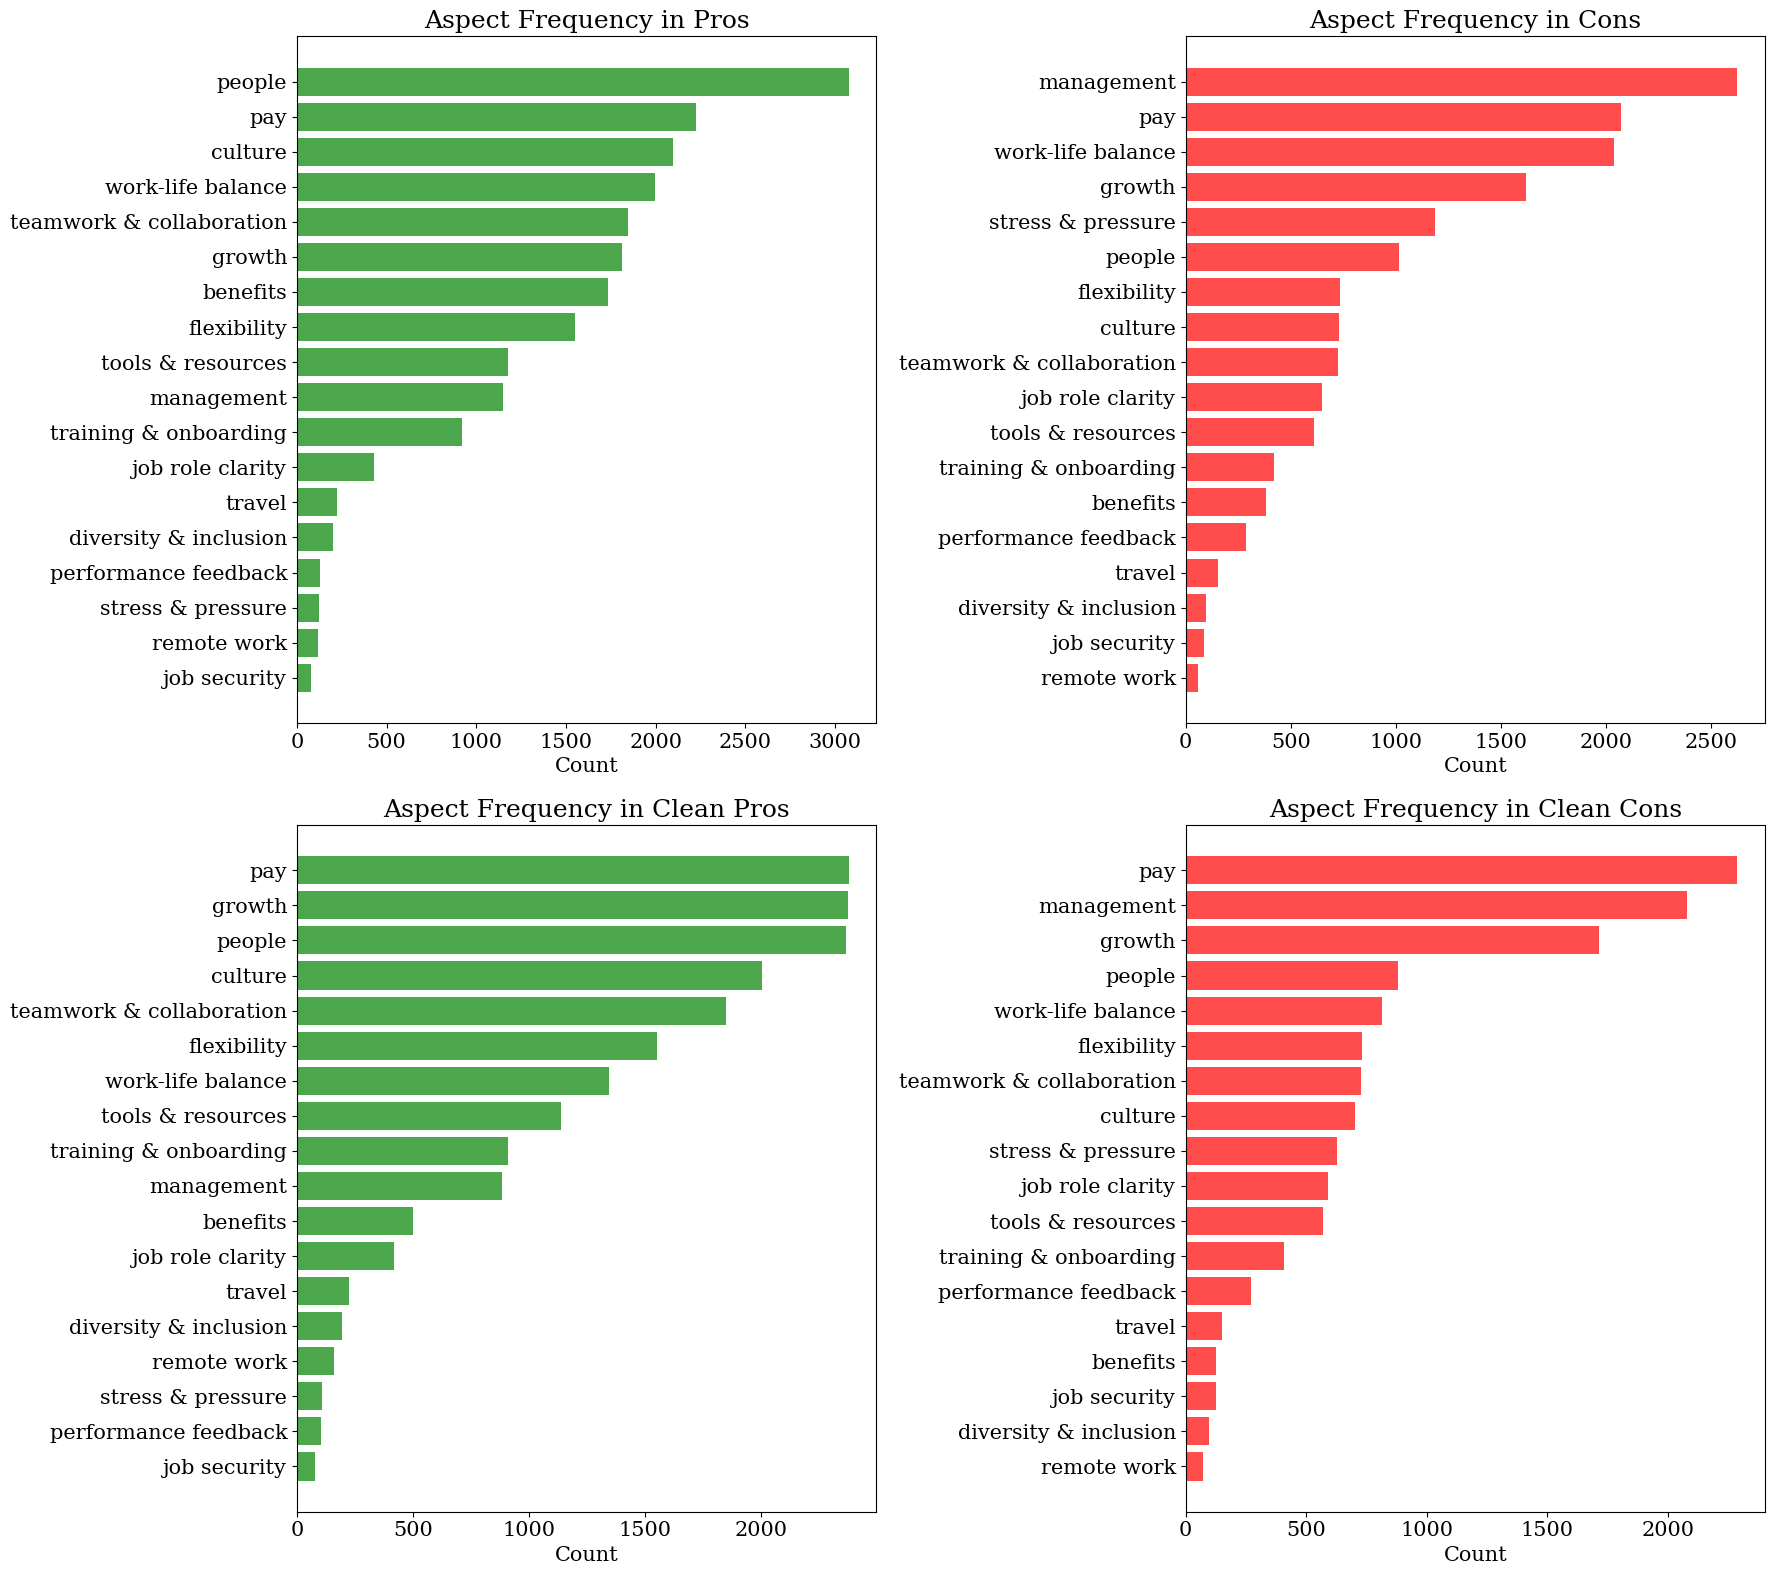

In [14]:
import matplotlib.pyplot as plt

# Prepare data (already done earlier)
# pro_data, con_data, pro_data_clean, con_data_clean assumed to be available

# Create 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(18, 16))  # Wider and taller figure for readability

# Plot 1: Pros
axs[0, 0].barh([a for a, c in pro_data], [c for a, c in pro_data], color='green', alpha=0.7)
axs[0, 0].set_title("Aspect Frequency in Pros")
axs[0, 0].set_xlabel("Count")

# Plot 2: Cons
axs[0, 1].barh([a for a, c in con_data], [c for a, c in con_data], color='red', alpha=0.7)
axs[0, 1].set_title("Aspect Frequency in Cons")
axs[0, 1].set_xlabel("Count")

# Plot 3: Clean Pros
axs[1, 0].barh([a for a, c in pro_data_clean], [c for a, c in pro_data_clean], color='green', alpha=0.7)
axs[1, 0].set_title("Aspect Frequency in Clean Pros")
axs[1, 0].set_xlabel("Count")

# Plot 4: Clean Cons
axs[1, 1].barh([a for a, c in con_data_clean], [c for a, c in con_data_clean], color='red', alpha=0.7)
axs[1, 1].set_title("Aspect Frequency in Clean Cons")
axs[1, 1].set_xlabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()


In [15]:
df_sample.to_csv('aspect_checsk.csv')

In [16]:
print("Uncleaned counts:")
print(f"{'Aspect':<25}{'Pros Count':>12}{'Cons Count':>12}")
print("-" * 50)

for aspect in all_aspects:
    pros = pro_counts.get(aspect, 0)
    cons = con_counts.get(aspect, 0)
    print(f"{aspect:<25}{pros:>12}{cons:>12}")


Uncleaned counts:
Aspect                     Pros Count  Cons Count
--------------------------------------------------
pay                              2223        2073
management                       1147        2627
work-life balance                1998        2038
growth                           1815        1618
stress & pressure                 121        1189
culture                          2099         732
diversity & inclusion             199          96
travel                            225         152
benefits                         1733         383
remote work                       115          58
flexibility                      1553         733
people                           3077        1016
training & onboarding             918         418
job role clarity                  427         651
tools & resources                1176         610
performance feedback              130         287
job security                       78          87
teamwork & collaboration       

In [17]:
print("Cleaned counts:")
print(f"{'Aspect':<25}{'Pros Count':>12}{'Cons Count':>12}")
print("-" * 50)

for aspect in all_aspects:
    pros = pro_counts_clean.get(aspect, 0)
    cons = con_counts_clean.get(aspect, 0)
    print(f"{aspect:<25}{pros:>12}{cons:>12}")


Cleaned counts:
Aspect                     Pros Count  Cons Count
--------------------------------------------------
pay                              2379        2288
management                        884        2077
work-life balance                1344         816
growth                           2374        1715
stress & pressure                 107         629
culture                          2006         702
diversity & inclusion             194          96
travel                            225         152
benefits                          500         127
remote work                       161          73
flexibility                      1553         733
people                           2366         882
training & onboarding             912         407
job role clarity                  417         588
tools & resources                1138         568
performance feedback              104         271
job security                       78         126
teamwork & collaboration         

## Aggregate the aspects per company

In [18]:
# 1–2. Flatten aspect sentiment results from pro + con columns
from collections import defaultdict

def flatten_aspect_sentiments(row, source):
    results = []
    firm = row.get('firm') or row.get('company')  # fallback
    sentiments = row.get(source, {})
    for aspect, scores in sentiments.items():
        # Aggregate actual star rating (1–5)
        rating = scores.get("label")
        all_stars = {i: scores.get(i, 0.0) for i in range(1, 6)}

        results.append({
            "firm": firm,
            "aspect": aspect,
            "source": source.replace('_aspect_sentiments', ''),  # 'pro' or 'con'
            "star_rating": rating,
            **all_stars
        })
    return results

# 3. Apply to full dataset
flattened = []
for _, row in df_sample.iterrows():
    flattened += flatten_aspect_sentiments(row, 'pro_aspect_sentiments')
    flattened += flatten_aspect_sentiments(row, 'con_aspect_sentiments')

flat_df = pd.DataFrame(flattened)

# 4. Aggregate star ratings + count mentions per company/aspect
company_aspect_matrix = flat_df.groupby(['firm', 'aspect'])['star_rating'].agg(
    avg_star_rating='mean',
    n_mentions='count'
).reset_index()
company_aspect_pivot = company_aspect_matrix.pivot(
    index='firm',
    columns='aspect',
    values='avg_star_rating'
)


# 6. Export
company_aspect_matrix.to_csv('company_aspect_matrix_with_counts.csv', index=False)
company_aspect_pivot.to_csv('company_aspect_matrix_wide.csv', index=False)


In [19]:
company_aspect_matrix

,firm,aspect,avg_star_rating,n_mentions
0,AFH-Wealth-Management,benefits,3.000000,2
1,AFH-Wealth-Management,culture,5.000000,1
2,AFH-Wealth-Management,management,3.333333,3
3,AFH-Wealth-Management,pay,5.000000,1
4,AFH-Wealth-Management,people,2.500000,2
...,...,...,...,...
4623,the-LEGO-Group,pay,3.250000,4
4624,the-LEGO-Group,people,3.500000,6
4625,the-LEGO-Group,teamwork & collaboration,2.666667,3
4626,the-LEGO-Group,tools & resources,1.000000,1


In [20]:
company_aspect_pivot

aspect,benefits,culture,diversity & inclusion,flexibility,growth,job role clarity,job security,management,pay,people,performance feedback,remote work,stress & pressure,teamwork & collaboration,tools & resources,training & onboarding,travel,work-life balance
firm,,,,,,,,,,,,,,,,,,
AFH-Wealth-Management,3.00,5.000000,NaN,NaN,NaN,NaN,NaN,3.333333,5.000000,2.500000,2.5,NaN,NaN,2.500000,NaN,3.000000,NaN,4.000000
AJ-Bell,2.25,5.000000,NaN,NaN,4.428571,NaN,NaN,4.500000,3.333333,5.000000,NaN,NaN,NaN,4.250000,5.000000,5.000000,NaN,NaN
ALDI,4.00,3.083333,NaN,2.346154,3.400000,2.642857,4.0,1.608696,3.960000,3.533333,2.5,NaN,1.428571,3.909091,1.250000,3.400000,NaN,2.391304
AQA,3.50,4.000000,NaN,4.000000,2.333333,NaN,NaN,2.333333,2.333333,3.000000,NaN,NaN,2.000000,3.000000,NaN,4.000000,NaN,4.000000
ASDA,3.60,3.296296,NaN,2.953125,2.269231,2.733333,1.0,1.864198,2.954023,3.424242,NaN,NaN,1.500000,3.615385,2.300000,2.153846,NaN,2.677083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YOOX-NET-A-PORTER-GROUP,2.50,1.571429,NaN,1.500000,1.600000,1.000000,NaN,1.000000,2.000000,1.000000,NaN,NaN,NaN,1.750000,3.000000,NaN,NaN,2.000000
ibis,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
mydentist-UK,NaN,NaN,NaN,NaN,1.000000,2.500000,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,4.000000,NaN,4.000000,NaN,NaN


## Javi

### Comparing top_aspects with aspects dictionary:

In [22]:
# 1. Normalise everything to lowercase
existing_keys = {k.lower() for k in aspect_groups.keys()}

# flatten every keyword in the dictionary
existing_keywords = {kw.lower() for kws in aspect_groups.values() for kw in kws}

# 2. Compare
# a) aspects that are missing entirely
missing_new_keys = [asp for asp in top_aspects
                    if asp.lower() not in existing_keys
                    and asp.lower() not in existing_keywords]

# b) aspects that already exist as *keywords* but not as a top‑level key
present_as_keyword = [asp for asp in top_aspects
                      if asp.lower() not in existing_keys    # not a key
                      and asp.lower() in existing_keywords]  # but inside values

print("🔍 Candidates to ADD as new keys:")
for asp in missing_new_keys:
    print("  •", asp)

print("\n✅ Already present as a keyword (maybe promote to key?):")
for asp in present_as_keyword:
    print("  •", asp)

🔍 Candidates to ADD as new keys:
  • staff
  • discount
  • employees
  • content
  • manager
  • food
  • customers
  • university
  • skills
  • brand
  • ceo
  • employee benefits
  • locations
  • facilities
  • courses
  • money
  • teams
  • learn
  • canteen
  • learning
  • place
  • holidays
  • meals
  • everyone
  • recruitment
  • office
  • promotions
  • conditions
  • paid
  • systems
  • reward
  • benefit
  • opportunities
  • meal
  • job
  • commission
  • services
  • work
  • location
  • pros
  • company
  • clients
  • health
  • employee
  • offices
  • knowledge
  • wages
  • projects
  • business
  • jobs
  • crew
  • discounts
  • project
  • employment
  • workplace
  • research
  • paced
  • campus
  • time
  • service
  • shifts
  • salaries
  • events
  • lifestyle
  • mix
  • student
  • working
  • contract
  • students
  • package
  • management team
  • paced environment
  • workers
  • space
  • experience
  • partners
  • building
  • benefits packa

In [24]:
modified_aspect_groups = {
    "pay": ["pay", "salary", "compensation", "wage", "income", "bonus"],
    "management": ["management", "managers", "leadership", "boss", "supervisor"],
    "work-life balance": ["work-life balance", "balance", "working hours", "hours", "flexibility", "overtime", "holiday"],
    "growth": ["growth", "grow", "career", "promotion", "advancement", "development", "opportunity", "progress"],
    "stress & pressure": ["stress", "pressure", "burnout", "demanding", "high pressure", "overload", "long hours", "stressful"],
    "culture": ["culture", "environment", "atmosphere", "company culture", "values"],
    "diversity & inclusion": ["diversity", "inclusion", "equality", "equity", "inclusive", "minority", "belonging"],
    "travel": ["travel", "commute", "commuting", "relocation", "mobility"],
    "benefits": ["benefits", "perks", "healthcare", "insurance", "pension", "rewards", "gym", "lunch", "dental"],
    "remote work": ["remote", "work from home", "wfh", "home office", "hybrid", "telework"],
    "flexibility": ["flexible", "flexibility", "adjustable schedule", "shift", "adaptable"],
    "people": ["people", "colleagues", "collegues", "coworker", "coworkers", "community", "teammates"],
    "training & onboarding": ["training", "onboarding", "orientation", "new hire", "introduction", "induction"],
    "job role clarity": ["role", "responsibility", "job description", "tasks", "duties", "expectation", "scope"],
    "tools & resources": ["tools", "resources", "equipment", "software", "support", "access", "tech stack", "technology"],
    "performance feedback": ["feedback", "review", "appraisal", "evaluation", "performance", "supervision", "goals"],
    "job security": ["job security", "layoff", "firing", "termination", "redundancy", "stable job"],
    "teamwork & collaboration": ["team", "teamwork", "collaboration", "supportive", "helpful", "team spirit", "group"]
}

for asp in missing_new_keys:
    modified_aspect_groups[asp] = [asp]

print(modified_aspect_groups)

{'pay': ['pay', 'salary', 'compensation', 'wage', 'income', 'bonus'], 'management': ['management', 'managers', 'leadership', 'boss', 'supervisor'], 'work-life balance': ['work-life balance', 'balance', 'working hours', 'hours', 'flexibility', 'overtime', 'holiday'], 'growth': ['growth', 'grow', 'career', 'promotion', 'advancement', 'development', 'opportunity', 'progress'], 'stress & pressure': ['stress', 'pressure', 'burnout', 'demanding', 'high pressure', 'overload', 'long hours', 'stressful'], 'culture': ['culture', 'environment', 'atmosphere', 'company culture', 'values'], 'diversity & inclusion': ['diversity', 'inclusion', 'equality', 'equity', 'inclusive', 'minority', 'belonging'], 'travel': ['travel', 'commute', 'commuting', 'relocation', 'mobility'], 'benefits': ['benefits', 'perks', 'healthcare', 'insurance', 'pension', 'rewards', 'gym', 'lunch', 'dental'], 'remote work': ['remote', 'work from home', 'wfh', 'home office', 'hybrid', 'telework'], 'flexibility': ['flexible', 'fle

In [25]:
from pprint import pprint

pprint(modified_aspect_groups, compact=False, width=120)


{'academics': ['academics'],
 'admin': ['admin'],
 'administration': ['administration'],
 'annual leave': ['annual leave'],
 'area': ['area'],
 'attitude': ['attitude'],
 'bank': ['bank'],
 'benefit': ['benefit'],
 'benefits': ['benefits', 'perks', 'healthcare', 'insurance', 'pension', 'rewards', 'gym', 'lunch', 'dental'],
 'benefits package': ['benefits package'],
 'bonuses': ['bonuses'],
 'bosses': ['bosses'],
 'brand': ['brand'],
 'break': ['break'],
 'breaks': ['breaks'],
 'budgets': ['budgets'],
 'building': ['building'],
 'buildings': ['buildings'],
 'bullying': ['bullying'],
 'bureaucracy': ['bureaucracy'],
 'bureaucratic': ['bureaucratic'],
 'business': ['business'],
 'campus': ['campus'],
 'canteen': ['canteen'],
 'career progression': ['career progression'],
 'ceo': ['ceo'],
 'challenges': ['challenges'],
 'change': ['change'],
 'christmas': ['christmas'],
 'client': ['client'],
 'clients': ['clients'],
 'club': ['club'],
 'coffee': ['coffee'],
 'cog': ['cog'],
 'commission':

### Manually grouping aspects into key - keyword pairs:

In [ ]:
modified_aspect_groups = {
'academics': ['academics'],
 'administration': ['administration','admin'],
 'annual leave': ['annual leave'],
 'attitude': ['attitude'],
 'bank': ['bank'],
 'benefit': ['benefit','benefits', 'perks', 'healthcare', 'insurance', 'pension', 'rewards', 'gym', 'lunch', 'dental','benefits package'],
 'brand': ['brand'],
 'break': ['break', 'breaks'],
 'budgets': ['budgets'],
 'building': ['building','buildings','facilities','space','room'],
 'bullying': ['bullying'],
 'bureaucracy': ['bureaucracy','bureaucratic', 'red tape', 'tape'],
 'business': ['business'],
 'campus': ['campus'],
 'canteen': ['canteen'],
 'career progression': ['career progression'],
 'challenges': ['challenges'],
 'change': ['change'],
 'christmas': ['christmas'],
 'club': ['club'],
 'coffee': ['coffee'],
 'cog': ['cog'],
 'commission': ['commission'],
 'communication': ['communication','communications'],
 'company': ['company'],
 'conditions': ['conditions'],
 'cons': ['cons'],
 'content': ['content'],
 'contract': ['contract'],
 'contracts': ['contracts'],
 'cost': ['cost'],
 'courses': ['courses'],
 'crew': ['crew'],
 'culture': ['culture', 'environment', 'atmosphere', 'company culture', 'values'],
 'customers': ['customers','client','clients'],
 'day': ['day'],
 'days': ['days'],
 'delivery': ['delivery'],
 'department': ['department'],
 'departments': ['departments'],
 'directors': ['directors'],
 'discount': ['discount', 'discounts'],
 'diversity & inclusion': ['diversity', 'inclusion', 'equality', 'equity', 'inclusive', 'minority', 'belonging'],
 'downsides': ['downsides'],
 'dress code': ['dress code'],
 'drink': ['drink'],
 'drinks': ['drinks'],
 'employee': ['employee'],
 'employee benefits': ['employee benefits'],
 'employees': ['employees'],
 'employer': ['employer'],
 'employment': ['employment'],
 'enviroment': ['enviroment'],
 'events': ['events'],
 'everyone': ['everyone'],
 'experience': ['experience'],
 'family': ['family'],
 'fashion': ['fashion'],
 'fees': ['fees'],
 'flexibility': ['flexible', 'flexibility', 'adjustable schedule', 'shift', 'adaptable'],
 'food': ['food'],
 'gossip': ['gossip'],
 'growth': ['growth', 'grow', 'career', 'promotion', 'advancement', 'development', 'opportunity', 'progress'],
 'health': ['health'],
 'holidays': ['holidays'],
 'hr': ['hr'],
 'incentives': ['incentives'],
 'infrastructure': ['infrastructure'],
 'innovation': ['innovation'],
 'interaction': ['interaction'],
 'interview': ['interview'],
 'it': ['it'],
 'job': ['job'],
 'job role clarity': ['role', 'responsibility', 'job description', 'tasks', 'duties', 'expectation', 'scope'],
 'job security': ['job security', 'layoff', 'firing', 'termination', 'redundancy', 'stable job'],
 'jobs': ['jobs'],
 'knowledge': ['knowledge'],
 'kpi': ['kpi'],
 'leaders': ['leaders'],
 'learn': ['learn'],
 'learning': ['learning'],
 'learnt': ['learnt'],
 'lecturer': ['lecturer'],
 'life balance': ['life balance'],
 'lifestyle': ['lifestyle'],
 'location': ['location','locations','area'],
 'management': ['management', 'managers', 'leadership', 'boss', 'supervisor','ceo','bosses','directors','management structure','management team','middle management'],
 'meal': ['meal'],
 'meals': ['meals'],
 'mix': ['mix'],
 'money': ['money'],
 'morale': ['morale'],
 'nhs': ['nhs'],
 'office': ['office','office environment', 'office location', 'office space','offices'],
 'opportunities': ['opportunities'],
 'organisation': ['organisation'],
 'organization': ['organization'],
 'pace': ['pace'],
 'paced': ['paced'],
 'paced environment': ['paced environment'],
 'package': ['package'],
 'paid': ['paid'],
 'parking': ['parking'],
 'partners': ['partners'],
 'pay': ['pay', 'salary', 'compensation', 'wage', 'income', 'bonus','bonuses'],
 'pay rates': ['pay rates'],
 'payroll': ['payroll'],
 'pension scheme': ['pension scheme'],
 'people': ['people', 'colleagues', 'collegues', 'coworker', 'coworkers', 'community', 'teammates'],
 'performance feedback': ['feedback', 'review', 'appraisal', 'evaluation', 'performance', 'supervision', 'goals'],
 'place': ['place'],
 'places': ['places'],
 'policies': ['policies'],
 'politics': ['politics'],
 'price': ['price'],
 'process': ['process'],
 'processes': ['processes'],
 'progression': ['progression'],
 'project': ['project'],
 'projects': ['projects'],
 'promotions': ['promotions'],
 'pros': ['pros'],
 'qualifications': ['qualifications'],
 'quality': ['quality'],
 'range': ['range'],
 'rate': ['rate'],
 'recruitment': ['recruitment'],
 'remote work': ['remote', 'work from home', 'wfh', 'home office', 'hybrid', 'telework'],
 'research': ['research'],
 'resource': ['resource'],
 'retail': ['retail'],
 'reward': ['reward'],
 'roles': ['roles'],
 'rota': ['rota'],
 'rotas': ['rotas'],
 'safety': ['safety'],
 'salaries': ['salaries'],
 'sales': ['sales'],
 'security': ['security'],
 'senior management': ['senior management'],
 'service': ['service'],
 'services': ['services'],
 'shifts': ['shifts'],
 'sick pay': ['sick pay'],
 'skills': ['skills'],
 'social': ['social'],
 'staff': ['staff'],
 'staff members': ['staff members'],
 'staff turnover': ['staff turnover'],
 'staffing': ['staffing'],
 'stock': ['stock'],
 'store': ['store'],
 'strategy': ['strategy'],
 'stress & pressure': ['stress',
                       'pressure',
                       'burnout',
                       'demanding',
                       'high pressure',
                       'overload',
                       'long hours',
                       'stressful'],
 'structure': ['structure'],
 'student': ['student'],
 'students': ['students'],
 'supervisors': ['supervisors'],
 'sustainability': ['sustainability'],
 'system': ['system'],
 'systems': ['systems'],
 'talent': ['talent'],
 'targets': ['targets'],
 'teaching': ['teaching'],
 'teams': ['teams'],
 'teamwork & collaboration': ['team', 'teamwork', 'collaboration', 'supportive', 'helpful', 'team spirit', 'group'],
 'tech': ['tech'],
 'technologies': ['technologies'],
 'terms': ['terms'],
 'time': ['time'],
 'times': ['times'],
 'tools & resources': ['tools', 'resources', 'equipment', 'software', 'support', 'access', 'tech stack', 'technology'],
 'training & onboarding': ['training', 'onboarding', 'orientation', 'new hire', 'introduction', 'induction'],
 'travel': ['travel', 'commute', 'commuting', 'relocation', 'mobility'],
 'travelling': ['travelling'],
 'turnover': ['turnover'],
 'uniform': ['uniform'],
 'university': ['university'],
 'variety': ['variety'],
 'vision': ['vision'],
 'wages': ['wages'],
 'weekends': ['weekends'],
 'work': ['work'],
 'work environment': ['work environment'],
 'work-life balance': ['work-life balance', 'balance', 'working hours', 'hours', 'flexibility', 'overtime', 'holiday'],
 'workers': ['workers'],
 'working': ['working'],
 'workload': ['workload'],
 'workplace': ['workplace']}